In [9]:
import os

import numpy as np
from keras import Sequential
from keras.layers import Dropout, BatchNormalization, Dense, Flatten, MaxPooling2D, Conv2D
from datasets import load_dataset
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping
import seaborn as sns
import keras_tuner as kt

In [63]:
dataset = load_dataset("cmudrc/3d-printed-or-not")

Using custom data configuration cmudrc--3d-printed-or-not-c7389bae8477e941
Found cached dataset parquet (C:/Users/longb/.cache/huggingface/datasets/cmudrc___parquet/cmudrc--3d-printed-or-not-c7389bae8477e941/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [64]:
train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255)

In [65]:
target_size = (64, 64)
batch_size = 32
train_data_dir = './data/food/training'

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory('./data/food/validation', target_size=target_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory('./data/food/evaluation',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 7896 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [22]:
cnn = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=train_generator.image_shape),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Flatten(),
    Dropout(rate=.2),
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=.2),
    Dense(units=11, activation='softmax')
])
cnn.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

In [66]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

In [23]:
callbacks = [
    EarlyStopping(min_delta=.005, monitor='val_accuracy', patience=10, restore_best_weights=True)
]

history = cnn.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  batch_size=32,
                  epochs=30,
                  workers=-1,
                  callbacks=callbacks,
                  validation_data=validation_generator,
                  validation_steps=validation_steps)

Epoch 1/30
246/246 [==============================] - 59s 236ms/step - loss: 2.3632 - accuracy: 0.2525 - val_loss: 3.9878 - val_accuracy: 0.1443
Epoch 2/30
246/246 [==============================] - 59s 240ms/step - loss: 1.9440 - accuracy: 0.3320 - val_loss: 2.7365 - val_accuracy: 0.2054
Epoch 3/30
246/246 [==============================] - 60s 243ms/step - loss: 1.8018 - accuracy: 0.3697 - val_loss: 1.8820 - val_accuracy: 0.3839
Epoch 4/30
246/246 [==============================] - 58s 238ms/step - loss: 1.6823 - accuracy: 0.4138 - val_loss: 1.9106 - val_accuracy: 0.4062
Epoch 5/30
246/246 [==============================] - 60s 242ms/step - loss: 1.5775 - accuracy: 0.4589 - val_loss: 1.6060 - val_accuracy: 0.4345
Epoch 6/30
246/246 [==============================] - 58s 236ms/step - loss: 1.4883 - accuracy: 0.4893 - val_loss: 1.7779 - val_accuracy: 0.3973
Epoch 7/30
246/246 [==============================] - 59s 241ms/step - loss: 1.4161 - accuracy: 0.5113 - val_loss: 1.4625 - val_ac

<AxesSubplot: >

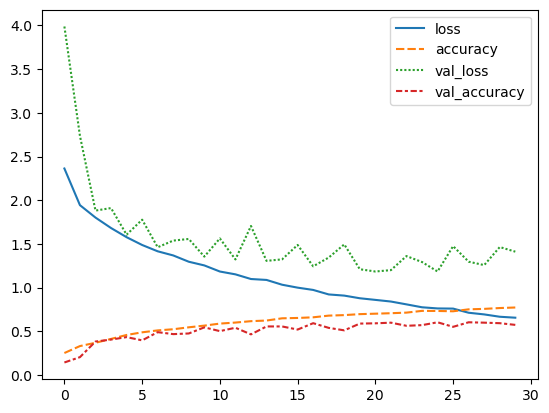

In [24]:
sns.lineplot(data=history.history)

### Hyperparam

In [16]:
def create_model(hp: kt.HyperParameters):
    model = Sequential()
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    first_filters = hp.Choice('first_filters', values=[16, 32, 64])
    conv_layers = hp.Int('conv_layers', min_value=1, max_value=4, step=1)
    activation = hp.Choice('activation', values=('relu', 'tanh'))

    for i in range(conv_layers):
        model.add(Conv2D(filters=2 ** i * first_filters, kernel_size=3, activation=activation))
        model.add(BatchNormalization())
        model.add(Conv2D(filters=2 ** i * first_filters, kernel_size=3, activation=activation))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=dropout))

    model.add(Flatten())
    model.add(Dropout(rate=dropout))

    dense_layers = hp.Int('dense_layers', min_value=1, max_value=4, step=1)
    dense_units = hp.Choice('dense_units', values=[64, 128, 256])

    for i in range(dense_layers):
        model.add(Dense(units=dense_units, activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout))

    model.add(Dense(units=11, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory=os.path.normpath('D:\githubRePos\Java5Klasse\DSML\\ann_image_classification\data'),
                     project_name='foodmodel')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10)
]

tuner.search(train_generator,
             steps_per_epoch=steps_per_epoch,
             epochs=20,
             callbacks=callbacks,
             validation_data=validation_generator,
             validation_steps=validation_steps)

Trial 22 Complete [00h 00m 02s]

Best val_accuracy So Far: 0.519345223903656
Total elapsed time: 00h 49m 21s
INFO:tensorflow:Oracle triggered exit


In [81]:
mod = create_model(tuner.get_best_hyperparameters(1)[0])

mod.load_weights(tf.train.latest_checkpoint('D:\githubRePos\Java5Klasse\DSML\\ann_image_classification\data\\foodmodel\\trial_0020'))

In [84]:
labels = ['Bread'
          'Dairy product'
          'Dessert'
          'Egg'
          'Fried food'
          'Meat'
          'Noodles-Pasta'
          'Rice'
          'Seafood'
          'Soup'
          'Vegetable-Fruit']

def beautify_prediction(prediction):
    max = 0
    maxIdx = 0
    for idx, i in enumerate(prediction[0]):
        print(f'{labels[idx]:>15s} {i:.2f}')
        if(i > max):
            max = i
            maxIdx = idx
    print("The image contains a " + labels[maxIdx])

In [85]:
from keras.preprocessing import image
def prepare_image(path):
    i = image.image_utils.load_img(path, target_size=target_size)
    image_array = image.image_utils.img_to_array(i)
    return np.expand_dims(image_array, axis=0)

In [91]:
img = prepare_image("./data/myImage/bread2.jpg")
beautify_prediction(mod.predict(img))

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_11/flatten_10/Reshape' defined at (most recent call last):
    File "C:\Users\longb\anaconda3\envs\dsai\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\longb\anaconda3\envs\dsai\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\longb\anaconda3\envs\dsai\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\longb\anaconda3\envs\dsai\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\longb\anaconda3\envs\dsai\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\longb\AppData\Local\Temp\ipykernel_31896\2644002042.py", line 2, in <module>
      beautify_prediction(mod.predict(img))
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\longb\anaconda3\envs\dsai\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_11/flatten_10/Reshape'
Input to reshape is a tensor with 14400 values, but the requested shape requires a multiple of 28800
	 [[{{node sequential_11/flatten_10/Reshape}}]] [Op:__inference_predict_function_169321]

Ich bin ehrlich, ich hab keine Ahnung was mein Fehler ist. Ich hab jetzt locker 4 Stunden probiert und keine Lösung gefunden. Ich gebe auf.